# Mask generating algorithm

In [3]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import os
import transformers
from accelerate import Accelerator
from transformers import ViTImageProcessor, ViTForImageClassification, ViTModel, ViTConfig, TrainingArguments, Trainer
from PIL import Image
import requests
import matplotlib.pyplot as plt
import numpy as np
import cv2
from datasets import load_dataset,load_metric
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

accelerator = Accelerator()
device = accelerator.device

/opt/crc/c/conda/23.5.2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


# Load Model

In [4]:
# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# url = "http://farm3.staticflickr.com/2066/1798910782_5536af8767_z.jpg"
# url = "http://farm1.staticflickr.com/184/399924547_98e6cef97a_z.jpg"
url = "http://farm1.staticflickr.com/128/318959350_1a39aae18c_z.jpg"
image = Image.open(requests.get(url, stream=True).raw)

pretrained_name = 'google/vit-base-patch16-224'
# pretrained_name = 'vit-base-patch16-224-finetuned-imageneteval'
# pretrained_name = 'openai/clip-vit-base-patch32'
config = ViTConfig.from_pretrained(pretrained_name)
processor = ViTImageProcessor.from_pretrained(pretrained_name)
# get mean and std to unnormalize the processed images
mean, std = processor.image_mean, processor.image_std

pred_model = ViTForImageClassification.from_pretrained(pretrained_name)
pred_model.to(device)
# set to eval mode
pred_model.eval()

with torch.no_grad():
    inputs = processor(images=image, return_tensors="pt")
    inputs.to(device)
    outputs = pred_model(**inputs, output_hidden_states=True)
    logits = outputs.logits
    # model predicts one of the 1000 ImageNet classes
    predicted_class_idx = logits.argmax(-1).item()
    print("Predicted class:", pred_model.config.id2label[predicted_class_idx])

Predicted class: golden retriever


# Load MaskGeneratingModel

In [5]:
from models.mask_generating_model import MaskGeneratingModel
mask_gen_model = MaskGeneratingModel(pred_model, hidden_size=config.hidden_size, num_classes=config.num_labels)
mask_gen_model.to(device)
mask_gen_model.load_state_dict(torch.load('mask_gen_model/mask_gen_model_1_0.pth'))
# mask_gen_model.load_state_dict(torch.load('mask_gen_model/mask_gen_model_final_4_79.pth'))


print()

## Show Example

# Demo trained examples

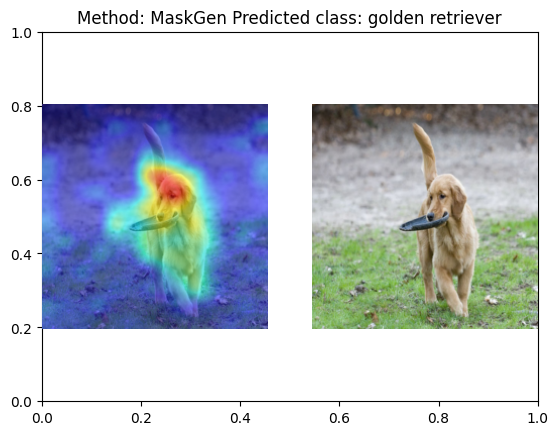

In [6]:
from utils.img_utils import plot_overlap_np

# url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
# url = "http://farm3.staticflickr.com/2066/1798910782_5536af8767_z.jpg"
# url = "http://farm1.staticflickr.com/184/399924547_98e6cef97a_z.jpg"
url = "http://farm1.staticflickr.com/128/318959350_1a39aae18c_z.jpg"
image = Image.open(requests.get(url, stream=True).raw)

with torch.no_grad():
    inputs = processor(images=image, return_tensors="pt")
    inputs.to(device)
    img = inputs['pixel_values']
    img = img.to(device)
    predicted_class_idx = pred_model(img).logits.argmax(-1).item()

plt.title(f"Method: MaskGen Predicted class: {pred_model.config.id2label[predicted_class_idx]}")
heatmap = mask_gen_model.attribute_img(img, image_size=224, patch_size=16)

heatmap = heatmap.squeeze(0).detach().cpu().numpy()
img = img.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)

img_int, heatmap_img = plot_overlap_np(img, heatmap, mean, std)

# Batch Evaluation

In [7]:
from torch.utils.data import DataLoader

def load_data(seed=42): 
    dataset = load_dataset("mrm8488/ImageNet1K-val")
    dataset = dataset['train']
    splits = dataset.train_test_split(test_size=0.1, seed=seed)
    test_ds = splits['test']
    splits = splits['train'].train_test_split(test_size=0.1, seed=seed)
    train_ds = splits['train']
    val_ds = splits['test']
    return train_ds, val_ds, test_ds

train_ds, _, test_ds = load_data()

normalize = Normalize(mean=processor.image_mean, std=processor.image_std)
if "height" in processor.size:
    size = (processor.size["height"], processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in processor.size:
    size = processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = processor.size.get("longest_edge")

transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess(example_batch):

    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

test_ds.set_transform(preprocess)
train_ds.set_transform(preprocess)

# batch size is limited to 2, because n_steps could could huge memory consumption
batch_size = 100
# test_dataloader = DataLoader(test_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)
test_dataloader = DataLoader(test_ds, batch_size=batch_size, collate_fn=collate_fn, shuffle=False)

Repo card metadata block was not found. Setting CardData to empty.


In [8]:
from evaluation import EvalGame
from tqdm import tqdm

# random_mask
root_path = 'results/maskgen-vit'
topk = 50

eval_game = EvalGame(model=lambda x : pred_model(pixel_values=x).logits, output_dim=1000)

def save_heatmap(heatmap, batch_size, idx, root_path):
    # convert to numpy
    heatmap = heatmap.detach().cpu().numpy() # [N, 1, 14, 14]
    tail_index = batch_size * (idx + 1)
    file_name = os.path.join(root_path, f"heatmap-{tail_index}")
    np.save(file_name, heatmap)
    
    return 0
    

ins_score_list = []
del_score_list = []
heatmap_list = []


for idx, data in tqdm(enumerate(test_dataloader)):
    pixel_values = data['pixel_values'].to(device)
    with torch.no_grad():
        pseudo_label = pred_model(pixel_values).logits.argmax(-1).view(-1)

    # sum up all 3 RGB channels for heatmap
    attr = mask_gen_model.attribute_img(pixel_values) # [1,14,14]

    # heatmap = attr.squeeze(1) # [1, 14, 14]
    heatmap = attr # [1, 14, 14]
    heatmap_list.append(heatmap)
    if (idx + 1) * batch_size % 100 == 0:
        heatmap_cat_tensor = torch.cat(heatmap_list, dim=0) # (N, 14, 14)
        save_heatmap(heatmap_cat_tensor, batch_size, idx, root_path)
        heatmap_list = []

    with torch.no_grad():
        input_img = pixel_values
        ins_score = eval_game.get_insertion_at_topk(input_img, heatmap, topk).detach()
        del_score = eval_game.get_deletion_at_topk(input_img, heatmap, topk).detach()

        # append to list
        ins_score_list.append(ins_score)
        del_score_list.append(del_score)
    
    if idx >= 2:
        break

if len(heatmap_list) > 0:
    heatmap_cat_tensor = torch.cat(heatmap_list, dim=0) # (N, 224, 224)
    save_heatmap(heatmap_cat_tensor, batch_size, idx, root_path)



2it [00:07,  3.68s/it]


In [9]:
ins_score = torch.cat(ins_score_list, dim=0)
del_score = torch.cat(del_score_list, dim=0)

print(ins_score.mean())
print(del_score.mean())
# heatmap = heatmap.squeeze(0).detach().cpu().numpy()
# img = input_img.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)

# img_int, heatmap_img = plot_overlap_np(img, heatmap, mean, std)

tensor(0.7401, device='cuda:0')
tensor(0.1701, device='cuda:0')


Predicted class: picket fence, paling


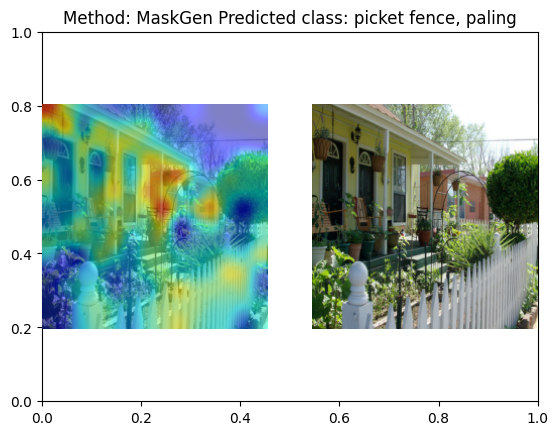

ins_score: tensor(0.8765, device='cuda:0')
del_score: tensor(0.1151, device='cuda:0')


In [21]:
from utils.img_utils import plot_overlap_np

idx = 42

predicted_class_idx = pseudo_label[idx].item()
print("Predicted class:", pred_model.config.id2label[predicted_class_idx])

hm = heatmap[idx].detach().cpu().numpy()
img = input_img[idx].detach().cpu().numpy().transpose(1, 2, 0)

plt.title(f"Method: MaskGen Predicted class: {pred_model.config.id2label[predicted_class_idx]}")
plt.annotate(f"ins_score: {ins_score_list[-1][idx]:.4f}", (0, 10))
plt.annotate(f"del_score: {del_score_list[-1][idx]:.4f}", (0, 20))

img_int, heatmap_img = plot_overlap_np(img, hm, mean, std)

print("ins_score:", ins_score_list[-1][idx])
print("del_score:", del_score_list[-1][idx])

In [11]:
heatmap[idx]

tensor([[0.4673, 0.5082, 0.5582, 0.5099, 0.4662, 0.4343, 0.5153, 0.5198, 0.5312,
         0.5290, 0.4858, 0.5613, 0.5517, 0.4986],
        [0.5315, 0.4153, 0.3928, 0.3828, 0.4651, 0.4690, 0.4689, 0.4875, 0.4368,
         0.5153, 0.5274, 0.5722, 0.5542, 0.5300],
        [0.2857, 0.4235, 0.4565, 0.4496, 0.4412, 0.4392, 0.4281, 0.5038, 0.4650,
         0.5045, 0.5401, 0.0877, 0.0888, 0.5082],
        [0.5676, 0.4917, 0.4767, 0.4724, 0.4699, 0.4818, 0.4253, 0.4652, 0.4609,
         0.5731, 0.5452, 0.5755, 0.5638, 0.5265],
        [0.5071, 0.5054, 0.5066, 0.4868, 0.0893, 0.0894, 0.5219, 0.5197, 0.4644,
         0.5570, 0.5024, 0.5330, 0.5317, 0.5708],
        [0.4872, 0.5033, 0.4890, 0.5107, 0.4137, 0.5144, 0.4802, 0.4777, 0.5495,
         0.5304, 0.5101, 0.4139, 0.5753, 0.5494],
        [0.5353, 0.5145, 0.4854, 0.4902, 0.3871, 0.4785, 0.5198, 0.4705, 0.5340,
         0.4296, 0.3978, 0.3633, 0.5477, 0.5649],
        [0.5065, 0.5349, 0.5275, 0.5076, 0.5015, 0.5005, 0.5128, 0.4564, 0.5542,
  

In [12]:
# from evaluation import EvalGame
# import os 
# import re
# from tqdm import tqdm


# root_path = 'results/mask-vit'
# model = lambda x: pred_model(pixel_values=x).logits
# eval_game = EvalGame(model=lambda x : pred_model(pixel_values=x).logits, output_dim=1000)
# topk = 50

# def extract_number(filename):
#     """
#     Extract the first occurance of countinuous numbers in a file name
#     """
#     match = re.search(r'\d+', filename)
#     if match:
#         return int(match.group(0))
#     return 0

# def get_ordered_filename_list(root_path):
#     file_path_list = []
#     for filename in os.listdir(root_path):
#         if filename.endswith('.npy'):
#             file_path = os.path.join(root_path, filename)
#             file_path_list.append(file_path)
#     file_path_list = sorted(file_path_list, key=extract_number)
#     return file_path_list


# def load_heatmap(root_path):
#     file_path_list = get_ordered_filename_list(root_path)
#     for filename in file_path_list:
#        yield np.load(filename)


# ins_score_list = []
# del_score_list = []

# heatmap_generator = load_heatmap(root_path)
# test_dataloader_iterator = iter(test_dataloader)
# for idx, data in tqdm(enumerate(heatmap_generator)):
#     heatmap = torch.tensor(data, device=device)

#     with torch.no_grad():
#         # Average pooling to convert to 14*14 heatmap
#         heatmap = F.avg_pool2d(heatmap, kernel_size=16, stride=16)
#         input_img = next(test_dataloader_iterator)['pixel_values'].to(device)
#         ins_score = eval_game.get_insertion_at_topk(input_img, heatmap, topk).detach()
#         del_score = eval_game.get_deletion_at_topk(input_img, heatmap, topk).detach()

#         # append to list
#         ins_score_list.append(ins_score)
#         del_score_list.append(del_score)

In [13]:
ins_score = torch.cat(ins_score_list, dim=0)
del_score = torch.cat(del_score_list, dim=0)
print(ins_score.mean())
print(del_score.mean())

tensor(0.7401, device='cuda:0')
tensor(0.1701, device='cuda:0')


In [14]:
ins_score = torch.cat(ins_score_list, dim=0)
del_score = torch.cat(del_score_list, dim=0)

In [15]:
ins_score.mean()

tensor(0.7401, device='cuda:0')

In [16]:
del_score.mean()

tensor(0.1701, device='cuda:0')

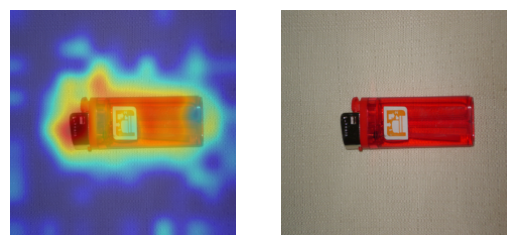

In [17]:
heatmap_example = heatmap[1].detach().cpu().numpy()
img_example = pixel_values[1].detach().cpu().numpy().transpose(1,2,0)

_, _ = plot_overlap_np(img_example, heatmap_example, mean, std)